In [39]:
import numpy as np
import matplotlib.pyplot as plt


hbar = 1           
m = 0.067          # efektywna masa elektronu w GaAs
L_nm = 100         # długość studni w nm
L = L_nm / 0.05292 # długość w jednostkach atomowych
N = 300            # liczba punktów siatki (zgodnie z zadaniem 1.1)
dx = L / N         # krok siatki

# Przeliczenie jednostek energii
meV_to_au = 1 / 27211.6
au_to_meV = 27211.6


In [40]:

# Metoda strzałów
def solve_wavefunction(E_meV, N, V=None):
    E_au = E_meV * meV_to_au
    dx_local = L / N
    psi = np.zeros(N + 1)
    psi[0] = 0.0
    psi[1] = 1.0  
    pref = 2.0 * m * dx_local**2 / hbar**2
    if V is None:
        V = np.zeros(N + 1)
        
    for i in range(1, N):
        psi[i+1] = 2 * psi[i] - psi[i-1] - pref * (E_au - V[i]) * psi[i]
        
    return psi

# Metoda bisekcji
def find_zero(E1_meV, E2_meV, N, V=None, tol_meV=1e-6, max_iter=300):
    f1 = solve_wavefunction(E1_meV, N, V)[-1]
    f2 = solve_wavefunction(E2_meV, N, V)[-1]
    
    if f1 * f2 > 0:
        return None
        
    for _ in range(max_iter):
        Em = 0.5 * (E1_meV + E2_meV)
        fm = solve_wavefunction(Em, N, V)[-1]
        
        if abs(E2_meV - E1_meV) < tol_meV:
            return Em
            
        if f1 * fm <= 0:
            E2_meV, f2 = Em, fm
        else:
            E1_meV, f1 = Em, fm
            
    return 0.5 * (E1_meV + E2_meV)

def find_all_zeros(N, V=None, E_min=-10.0, E_max=35.0, nE=3000):
    E_grid = np.linspace(E_min, E_max, nE)
    psiN_vals = np.array([solve_wavefunction(E, N, V)[-1] for E in E_grid])
    signs = np.sign(psiN_vals)
    change_idx = np.where(np.diff(signs) != 0)[0]
    zeros = []
    
    for i in change_idx:
        root = find_zero(E_grid[i], E_grid[i+1], N, V)
        if root is not None:
            zeros.append(root)
            
    return zeros

def normalize(psi, dx):
    I = dx * np.sum(psi**2)
    
    if I < 1e-15: 
        return psi * 0
        
    return psi / np.sqrt(I)

def central_barrier_potential(N, W_eV):
    V = np.zeros(N + 1)
    V[N // 2] = -W_eV * 1000 * meV_to_au  
    return V


In [41]:
# Metoda iteracji w czasie urojonym

alpha_crit = (m * dx**2) / hbar**2 
alpha_crit_meV_inv = alpha_crit * au_to_meV # W meV^{-1}

print(f"Krok siatki dx (au): {dx:.6e}")
print(f"Krytyczny parametr alfa (au): {alpha_crit:.6e}")
print(f"Krytyczny parametr alfa (meV^-1): {alpha_crit_meV_inv:.6e}")

# Hamiltonian
def apply_hamiltonian(psi, V, dx):
    N_local = len(psi) - 1
    Hpsi = np.zeros(N_local + 1)
       
    pref = -hbar**2 / (2.0 * m * dx**2) #Psi(0) = Psi(N) = Psi(N_local+1) = 0
    
    for i in range(1, N_local):
        kinetic = pref * (psi[i+1] + psi[i-1] - 2 * psi[i])
        potential = V[i] * psi[i]
        
        Hpsi[i] = kinetic + potential
        
    return Hpsi

# Psi' = (1 - alpha*H)*Psi
def itp_step(psi, V, alpha, dx):   
    Hpsi = apply_hamiltonian(psi, V, dx)
    
    psi_new = psi - alpha * Hpsi
    
    return psi_new


Krok siatki dx (au): 6.298816e+00
Krytyczny parametr alfa (au): 2.658230e+00
Krytyczny parametr alfa (meV^-1): 7.233470e+04


In [42]:
def solve_itp(N, alpha, V=None, target_E_state=1, orto_psi=None, tol_E=1e-6, max_iter=10000):
    """
    Główna funkcja ITP.
    target_E_state=1 (stan podstawowy): orto_psi jest ignorowane.
    target_E_state=2 (1. stan wzbudzony): orto_psi to funkcja Psi_1.
    """
    
    dx_local = L / N
    
    if V is None:
        V = np.zeros(N + 1)
        
    # Inicjalizacja: losowa funkcja falowa, znormalizowana (z wyzerowanymi brzegami)
    psi = np.random.rand(N + 1)

    psi[0] = 0.0
    psi[N] = 0.0
    
    E_history = []
    diff_E_hist = []

    for n in range(max_iter):
        
        # 1. Krok ITP
        psi_prime = itp_step(psi, V, alpha, dx_local)
        
        # 2. Ortonormalizacja i Normalizacja
        if target_E_state > 1 and orto_psi is not None:
            c1 = dx_local * np.sum(orto_psi * psi_prime) 
            
            psi_prime -= c1 * orto_psi
        
        psi_new = normalize(psi_prime, dx_local)
        
        # 3. Obliczanie energii oczekiwanej
        Hpsi_new = apply_hamiltonian(psi_new, V, dx_local)
        # Calka z Psi^* * HPsi * dx
        E_au = dx_local * np.sum(psi_new * Hpsi_new) 
        E_meV = E_au * au_to_meV
        E_history.append(E_meV)
        # 4. Sprawdzenie zbieżności
        if n > 0:
            diff_E = abs(E_history[n] - E_history[n-1])
            diff_E_hist.append(diff_E)
            if diff_E < tol_E:
                print(f"ITP converged after {n+1} iterations. E = {E_meV:.6f} meV for alpha = {alpha:.6e}")
                break
        
        psi = psi_new
        
    return E_meV, psi, E_history, diff_E_hist


ZADANIE 1.2: Badanie zbieżności ITP (W=0 meV)
ITP converged after 12501 iterations. E = 0.563601 meV for alpha = 1.329115e+00
ITP converged after 6791 iterations. E = 0.562490 meV for alpha = 2.525319e+00
ITP converged after 16940 iterations. E = 20472.905319 meV for alpha = 2.791142e+00


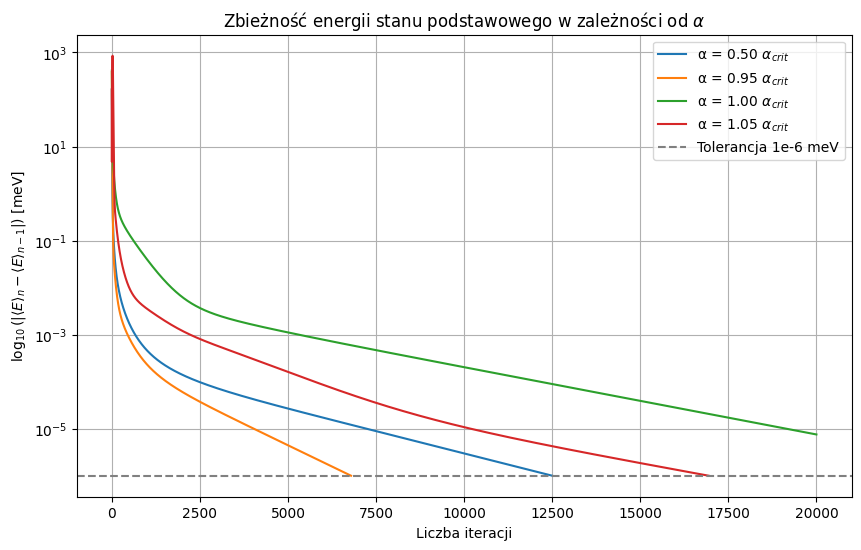

ITP converged after 11294 iterations. E = 0.563576 meV for alpha = 1.329115e+00
ITP converged after 7479 iterations. E = 0.562487 meV for alpha = 2.525319e+00


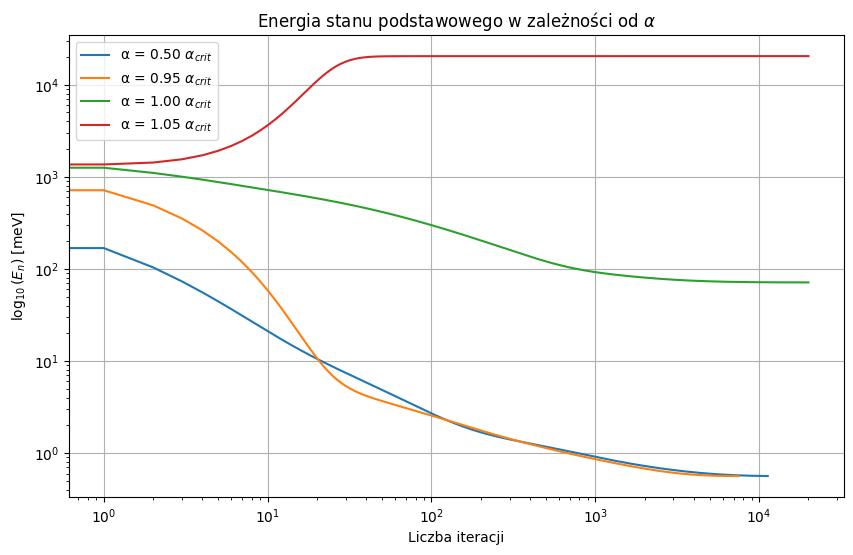

In [43]:
print("ZADANIE 1.2: Badanie zbieżności ITP (W=0 meV)")
tol_E = 1e-6
N_itp = 300 
dx_itp = L / N_itp
V_zero = np.zeros(N_itp + 1)
alpha_crit_itp = (m * dx_itp**2) / hbar**2

# Wartości alfa do przetestowania (blisko α_crit)
alpha_values = [0.5*alpha_crit, 0.95 * alpha_crit_itp, alpha_crit_itp, 1.05 * alpha_crit_itp]


plt.figure(figsize=(10, 6))

for alpha in alpha_values:
    E_val, psi_val, E_hist, diff_E_hist = solve_itp(N_itp, alpha, V=V_zero, tol_E=tol_E, max_iter=20000)

    E_diff = np.abs(np.array(diff_E_hist))

    # Wykres logarytmiczny zbierznosci
    plt.plot(np.arange(len(E_diff)), E_diff, label=f"α = {alpha/alpha_crit_itp:.2f} $\\alpha_{{crit}}$")
    
    
plt.yscale('log')
plt.xlabel("Liczba iteracji")
plt.ylabel(r"$\log_{10}(| \langle E \rangle_{n} - \langle E \rangle_{n-1} |)$ [meV]")
plt.title("Zbieżność energii stanu podstawowego w zależności od $\\alpha$")
plt.axhline(tol_E, color='gray', linestyle='--', label="Tolerancja 1e-6 meV")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))

for alpha in alpha_values:
    E_val, psi_val, E_hist, diff_E_hist = solve_itp(N_itp, alpha, V=V_zero, tol_E=tol_E, max_iter=20000)

    # Wykres energii
    plt.plot(np.arange(len(E_hist)), E_hist, label=f"α = {alpha/alpha_crit_itp:.2f} $\\alpha_{{crit}}$")
    
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Liczba iteracji")
plt.ylabel(r"$\log_{10}(E_{n} )$ [meV]")
plt.title("Energia stanu podstawowego w zależności od $\\alpha$")
plt.legend()
plt.grid(True)
plt.show()


ZADANIE 1.3/1.4: Stan podstawowy (E1) i wzbudzony (E2) (W=0 meV)
ITP converged after 6687 iterations. E = 0.562668 meV for alpha = 2.525319e+00
E1 (ITP) = 0.562668 meV (Iter: 6687)
E2 (ITP) = 2.271898 meV (Iter: 20000)


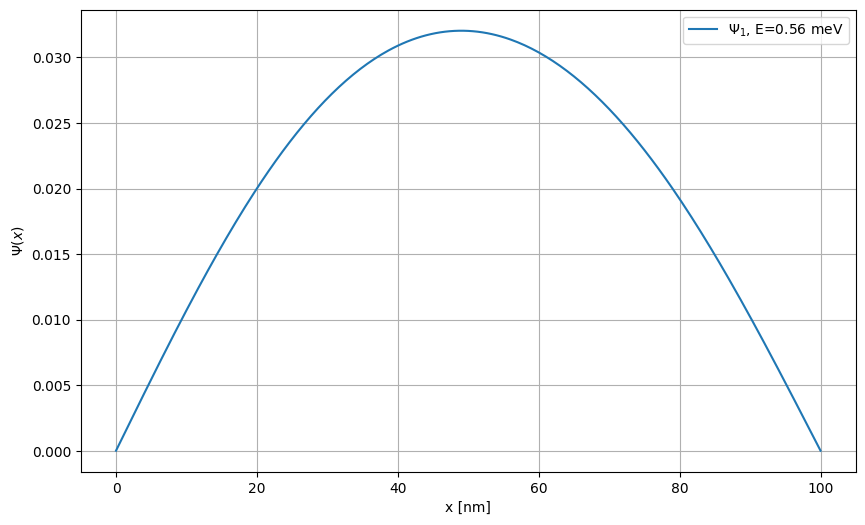

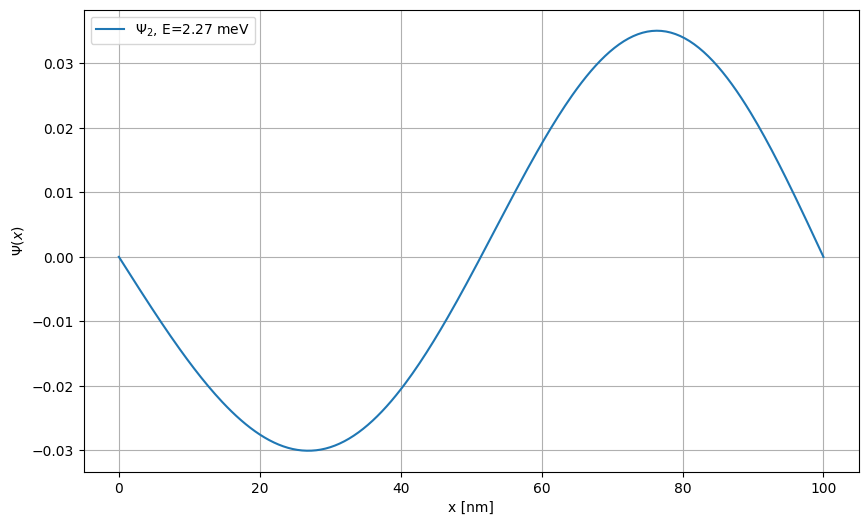

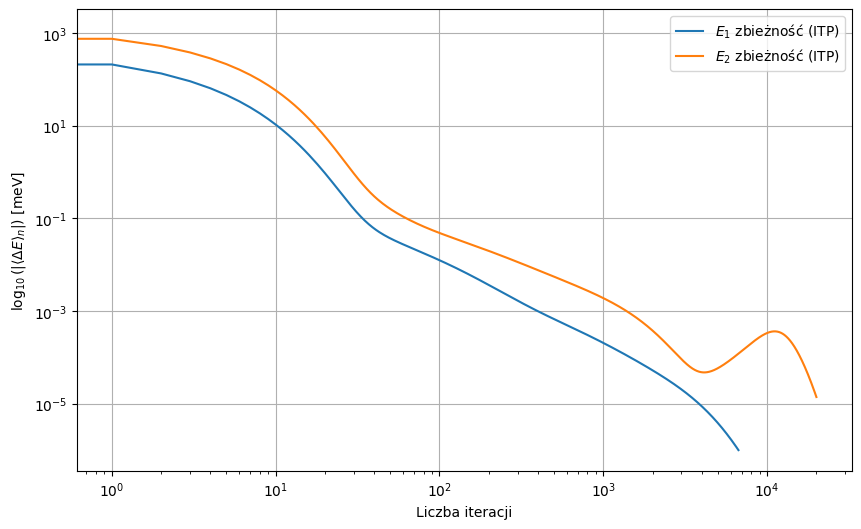

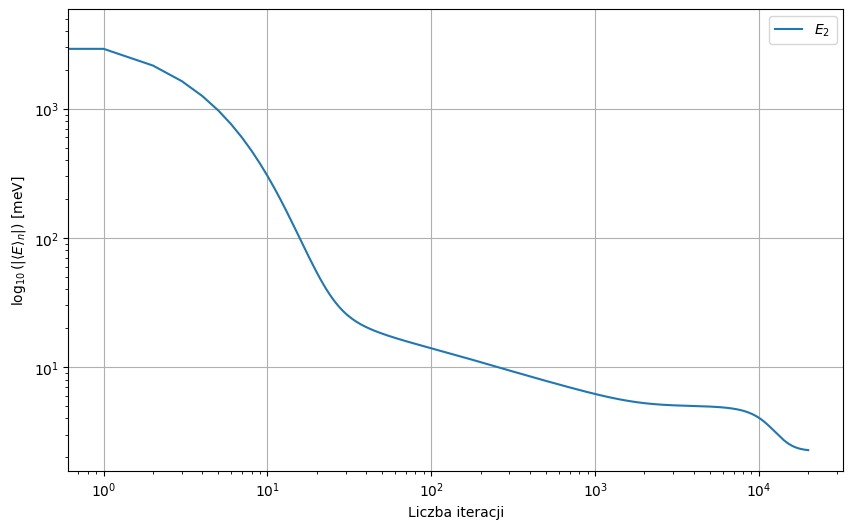

In [48]:
print("ZADANIE 1.3/1.4: Stan podstawowy (E1) i wzbudzony (E2) (W=0 meV)")

# Optymalne alfa (blisko α_crit, ale mniejsze)
alpha_opt = 0.95 * alpha_crit_itp
max_iter_long = 20000

# E1 i Psi1: Stan podstawowy

E1_itp, Psi1_itp, E1_hist, diff_E1_hist = solve_itp(N_itp, alpha_opt, V=V_zero, target_E_state=1, tol_E=1e-6, max_iter=max_iter_long)
print(f"E1 (ITP) = {E1_itp:.6f} meV (Iter: {len(E1_hist)})")

# E2 i Psi2: Pierwszy stan wzbudzony
E2_itp, Psi2_itp, E2_hist, diff_E2_hist = solve_itp(N_itp, alpha_opt, V=V_zero, target_E_state=2, orto_psi=Psi1_itp, tol_E=1e-6, max_iter=max_iter_long)
print(f"E2 (ITP) = {E2_itp:.6f} meV (Iter: {len(E2_hist)})")

# Wykres funkcji falowych
x_nm = np.linspace(0, L_nm, N_itp + 1)

plt.figure(figsize=(10, 6))
# plt.plot(x_nm, Psi1_itp + E1_itp, label=f"$\\Psi_1$, E={E1_itp:.2f} meV")
plt.plot(x_nm, Psi1_itp , label=f"$\\Psi_1$, E={E1_itp:.2f} meV")

# plt.axhline(E1_itp, color='blue', linestyle='--')
plt.xlabel("x [nm]")
# plt.ylabel(r"$\Psi(x) + E$")
plt.ylabel(r"$\Psi(x)$")

# plt.title("Funkcja falowa $\\Psi_1$ z ITP (W=0 meV)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
# plt.plot(x_nm, Psi2_itp + E2_itp, label=f"$\\Psi_2$, E={E2_itp:.2f} meV")
plt.plot(x_nm, Psi2_itp, label=f"$\\Psi_2$, E={E2_itp:.2f} meV")

# plt.axhline(E2_itp, color='orange', linestyle='--')
plt.xlabel("x [nm]")
# plt.ylabel(r"$\Psi(x) + E$")
plt.ylabel(r"$\Psi(x)$")

# plt.title("Funkcja falowa $\\Psi_2$ z ITP (W=0 meV)")
plt.legend()
plt.grid(True)
plt.show()


# Wykres zbieżności energii E1 i E2
plt.figure(figsize=(10, 6))
# plt.plot(np.arange(len(E1_hist)), np.abs(np.array(E1_hist) - E1_itp), label="$E_1$ zbieżność (ITP)")
# plt.plot(np.arange(len(E2_hist)), np.abs(np.array(E2_hist) - E2_itp), label="$E_2$ zbieżność (ITP)")
plt.plot(np.arange(len(diff_E1_hist)), np.abs(diff_E1_hist), label="$E_1$ zbieżność (ITP)")
plt.plot(np.arange(len(diff_E2_hist)), np.abs(diff_E2_hist), label="$E_2$ zbieżność (ITP)")
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Liczba iteracji")
plt.ylabel(r"$\log_{10}(| \langle \Delta E \rangle_{n} |)$ [meV]")
# plt.title("Zbieżność energii stanów E1 i E2 (W=0 meV)")
plt.legend()
plt.grid(True)
plt.show()

# Wykres energii E1 i E2
plt.figure(figsize=(10, 6))
# plt.plot(np.arange(len(E1_hist)), np.abs(np.array(E1_hist) - E1_itp), label="$E_1$ zbieżność (ITP)")
# plt.plot(np.arange(len(E2_hist)), np.abs(np.array(E2_hist) - E2_itp), label="$E_2$ zbieżność (ITP)")
# plt.plot(np.arange(len(E1_hist)), E1_hist, label="$E_1$ ")
plt.plot(np.arange(len(E2_hist)), E2_hist, label="$E_2$ ")
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Liczba iteracji")
plt.ylabel(r"$\log_{10}(| \langle E \rangle_{n} |)$ [meV]")
# plt.title("Energia stanów E1 i E2 (W=0 meV)")
plt.legend()
plt.grid(True)
plt.show()


ZADANIE 1.5: E1 i E2 dla W = 500 meV
E1 (Strzałów) = -12.203629 meV
E2 (Strzałów) = 2.245085 meV
ITP converged after 6512 iterations. E = -12.203629 meV for alpha = 2.525319e+00
E1 (ITP) = -12.203629 meV (Iter: 6512)
  Różnica ITP vs Strzały: 7.514628e-08 meV
E2 (ITP) = 2.937440 meV (Iter: 20000)
  Różnica ITP vs Strzały: 6.923546e-01 meV


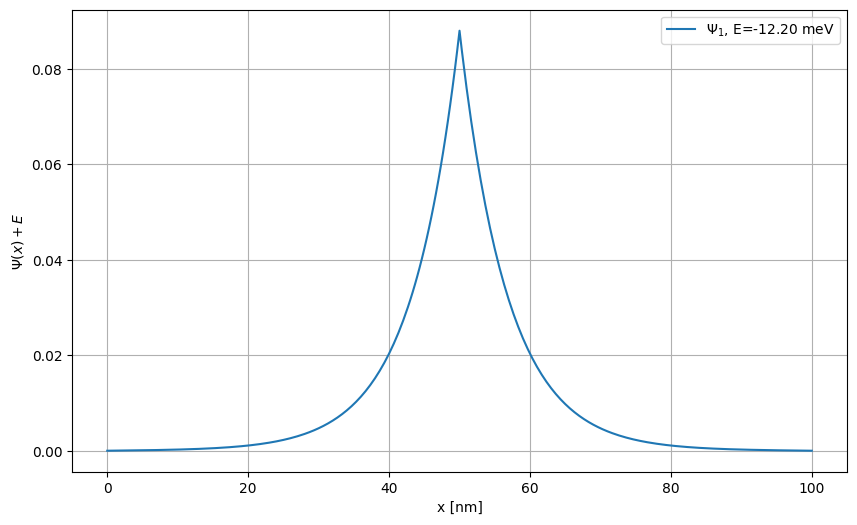

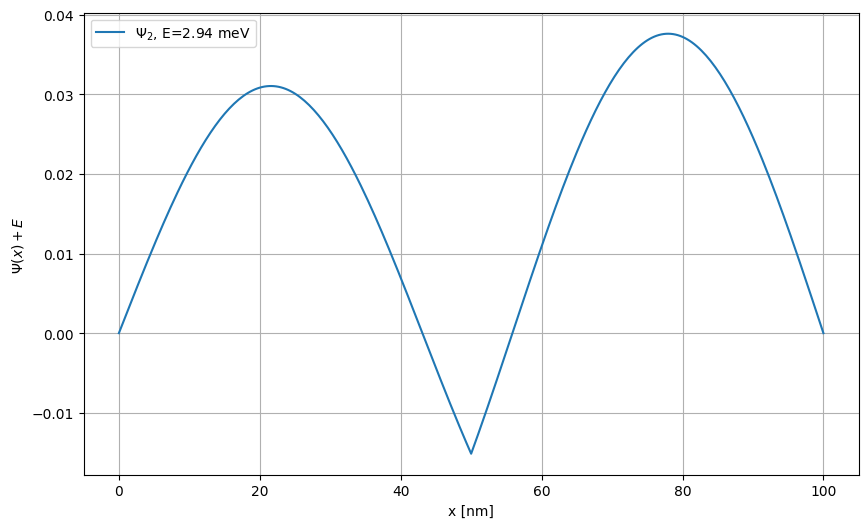

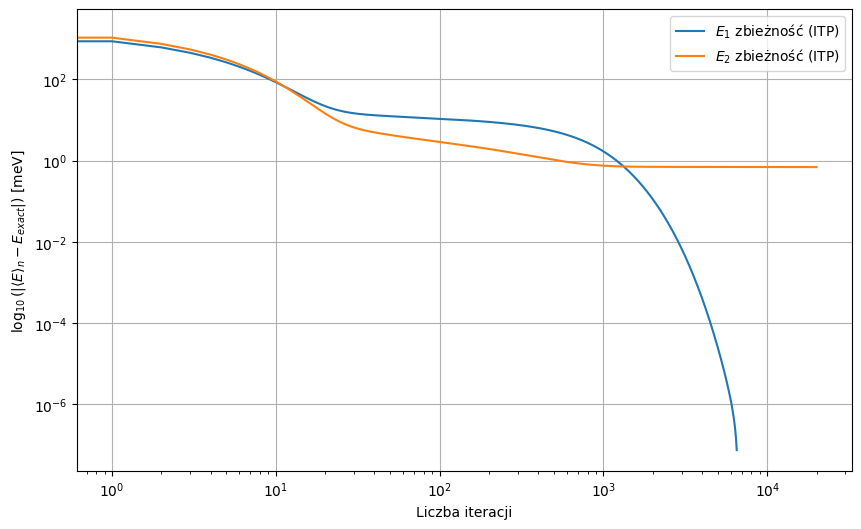

In [ ]:

print("ZADANIE 1.5: E1 i E2 dla W = 500 meV")

W_eV = 0.5  # 500 meV , potencjał jest ujemny w centrum dla W_eV > 0
V_barrier = central_barrier_potential(N_itp, W_eV) 

# Metoda strzałów (dla porównania)
E_zeros_shoot = find_all_zeros(N_itp, V=V_barrier, E_min=-500, E_max=50, nE=5000)
# E_zeros_shoot = find_all_zeros(N_itp, V=V_barrier, E_min=0, E_max=50, nE=5000)

if len(E_zeros_shoot) >= 2:
    E1_shoot = E_zeros_shoot[0]
    E2_shoot = E_zeros_shoot[1]
    print(f"E1 (Strzałów) = {E1_shoot:.6f} meV")
    print(f"E2 (Strzałów) = {E2_shoot:.6f} meV")
else:
    print("Metoda strzałów nie znalazła wystarczającej liczby stanów.")
    E1_shoot = None
    E2_shoot = None

# ITP: E1 i Psi1

E1_itp_W, Psi1_itp_W, E1_hist_W, diff_E1_hist_W = solve_itp(N_itp, alpha_opt, V=V_barrier, target_E_state=1, tol_E=1e-9, max_iter=max_iter_long)
print(f"E1 (ITP) = {E1_itp_W:.6f} meV (Iter: {len(E1_hist_W)})")
if E1_shoot is not None:
    print(f"  Różnica ITP vs Strzały: {abs(E1_itp_W - E1_shoot):.6e} meV")

# ITP: E2 i Psi2

E2_itp_W, Psi2_itp_W, E2_hist_W, diff_E2_hist_W = solve_itp(N_itp, alpha_opt, V=V_barrier, target_E_state=2, orto_psi=Psi1_itp_W, tol_E=1e-9, max_iter=max_iter_long)
print(f"E2 (ITP) = {E2_itp_W:.6f} meV (Iter: {len(E2_hist_W)})")
if E2_shoot is not None:
    print(f"  Różnica ITP vs Strzały: {abs(E2_itp_W - E2_shoot):.6e} meV")

# Wykres funkcji falowych dla W=500 meV
V_meV = V_barrier * au_to_meV 
V_plot = V_meV.copy()
V_plot[N_itp//2] = -W_eV * 1000 

plt.figure(figsize=(10, 6))
plt.plot(x_nm, Psi1_itp_W, label=f"$\\Psi_1$, E={E1_itp_W:.2f} meV")
# plt.plot(x_nm, V_plot, color='black', linestyle=':', label="Potencjał V(x)")
plt.xlabel("x [nm]")
plt.ylabel(r"$\Psi(x)$")
# plt.title("Funkcje falowe $\\Psi_1$  z ITP (W=500 meV, jama)")
plt.legend()
plt.grid(True)
# plt.ylim(V_plot.min() - 5, E2_itp_W + 1)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x_nm, Psi2_itp_W, label=f"$\\Psi_2$, E={E2_itp_W:.2f} meV")
# plt.plot(x_nm, V_plot, color='black', linestyle=':', label="Potencjał V(x)")
plt.xlabel("x [nm]")
plt.ylabel(r"$\Psi(x)$")
# plt.title("Funkcje falowe  $\\Psi_2$ z ITP (W=500 meV, jama)")
plt.legend()
plt.grid(True)
# plt.ylim(V_plot.min() - 5, E2_itp_W + 1)
plt.show()

# Wykres porównania z metoda strzałow w energii E1 i E2 dla W=500 meV

if E1_shoot is not None and E2_shoot is not None:
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(E1_hist_W)), np.abs(np.array(E1_hist_W) - E1_shoot), label="$E_1$ zbieżność (ITP)")
    plt.plot(np.arange(len(E2_hist_W)), np.abs(np.array(E2_hist_W) - E2_shoot), label="$E_2$ zbieżność (ITP)")
    plt.yscale('log')
    plt.xscale('log')

    plt.xlabel("Liczba iteracji")
    plt.ylabel(r"$\log_{10}(| \langle E \rangle_{n} - E_{exact} |)$ [meV]")
    # plt.title("Zbieżność energii stanów E1 i E2 (W=500 meV)")
    plt.legend()
    plt.grid(True)
    plt.show()